In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Defining the R script and loading the instance in Python

r = ro.r
r['source']('baseflow_sep.R')

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


ENG


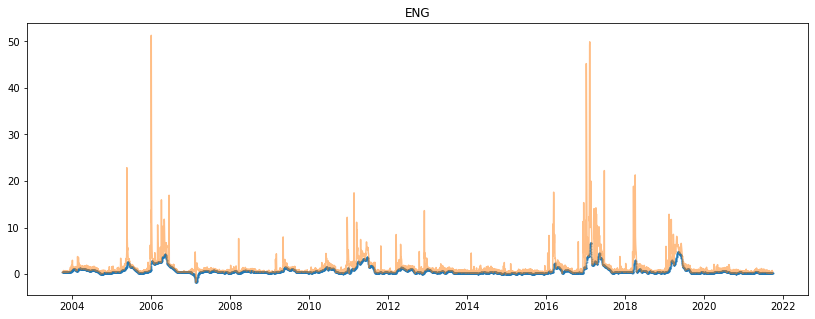

PAR


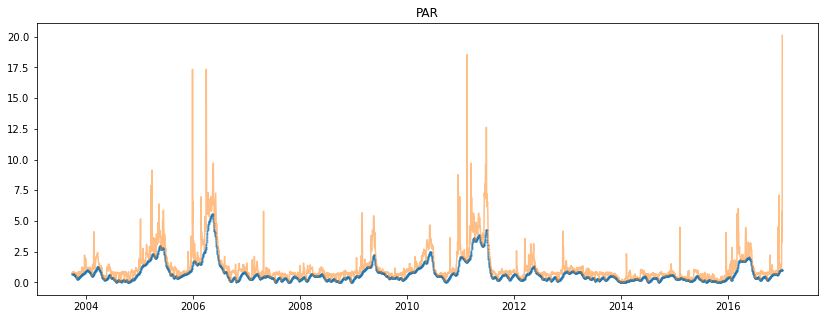

MIL


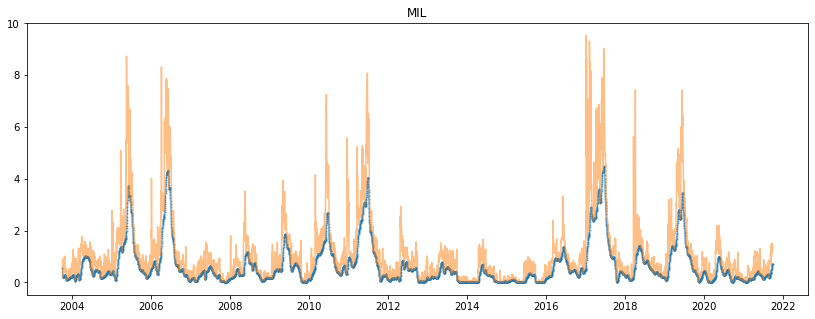

ISB


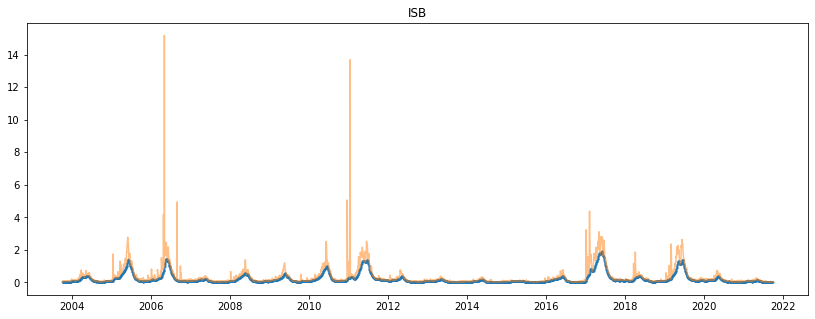

DNP


In [ ]:
# Loading the function we have defined in R.
baseflow_sep = ro.globalenv['get_baseflow']

# Reading and processing data
df = pd.read_csv("../data/CDEC/runoff.csv")#.set_index('date')
df.index = pd.to_datetime(df['date'])
nodata_stids = ["MCR", "CFW"]

stids = [x for x in df.columns if x not in nodata_stids]

df = df[stids].drop('date', axis = 1)

# Loop through cols 
for col in df.columns:
    print(col)

    # Select the column here 
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_pd_df = ro.conversion.py2rpy(df[col].dropna())    
        
    # Call the R function and getting the result
    runoff_df = baseflow_sep(r_pd_df)

    # Converting it back to a pandas dataframe.
    with localconverter(ro.default_converter + pandas2ri.converter):
        outdf = ro.conversion.rpy2py(runoff_df)

    outdf.index = df[col].dropna().index
    
    outdir = "../data/baseflow_sep"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    outfn = os.path.join(outdir, "{}_bfs.csv".format(col))
    if not os.path.exists(outfn):
        outdf.to_csv(outfn)
    
    plt.figure(figsize =(14,5))
    plt.title(col)
    plt.plot(outdf.index, outdf['bt'], marker = "o", markersize = 1, alpha = 0.5)
    plt.plot(outdf.index, outdf['bt'] + outdf['qft'],  markersize = 1, alpha = 0.5)
    plt.show()